<h1><center>PHYS-F-303</center></h1>
<h1><center>Partie numérique</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

In [31]:
import time
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

# Leçon 06_02

## Question 1

Le langage Python possède des fonctions précompilées pour générer des nombres distribués de différentes manières, notamment selon une gaussienne ou selon une exponentielle. 

### Distribution exponentielle

In [34]:
# random.expovariate

"""Exponential distribution. lambd is 1.0 divided by the desired mean. It should be nonzero. 
(The parameter would be called “lambda”, but that is a reserved word in Python.) 

Returned values range from 0 to positive infinity if lambd is positive, and from negative infinity
to 0 if lambd is negative"""

lambd = 1
distrExp = random.expovariate(lambd)
distrExp

0.85008094206369

In [ ]:
# numpy.random.exponential

""" Parameters:
    ----------
    lambd : float or array_like of floats

        The scale parameter, \beta = 1/\lambda.

    size : int or tuple of ints, optional

        Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. If size is None
        (default), a single value is returned if scale is a scalar. Otherwise, np.array(scale).size samples are
        drawn.

    Returns:
    -------
    out : ndarray or scalar

        Drawn samples from the parameterized exponential distribution."""

lambd = 1
size = 2



### Distribution gaussienne

In [38]:
# random.gauss

"""Gaussian distribution. mu is the mean, and sigma is the standard deviation"""

mu = 0
sigma = 1
distrGauss = random.gauss(mu,sigma)
distrGauss

0.43309040824794254

In [ ]:
# numpy.random.normal

""" Parameters:
    ----------
    mu : float or array_like of floats

        Mean (“centre”) of the distribution.

    sigma : float or array_like of floats

        Standard deviation (spread or “width”) of the distribution.

    size : int or tuple of ints, optional

        Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. If size is 
        None (default), a single value is returned if loc and scale are both scalars. 
        Otherwise, np.broadcast(loc, scale).size samples are drawn.

    Returns:
    -------
    out : ndarray or scalar

        Drawn samples from the parameterized normal distribution."""

mu = 0
sigma = 1
size = 1
distrNormal(mu,sigma,size)


In [47]:
# numpy.randn

"""Parameters:
   ----------
    d0, d1, ..., dn   : int, optional

                        The dimensions of the returned array, should be all positive. If no argument is 
                        given a single Python float is returned.

    Returns:
    -------
    Z   : ndarray or float

        (d0, d1, ..., dn)-shaped array of floating-point samples from the standard normal distribution, 
        or a single such float if no parameters were supplied."""

d0 = 2
d1 = 2
d2 = 2

distrNormal_randn = np.random.randn(d0,d1,d2)
distrNormal_randn

array([[[ 0.03719567,  0.65041628],
        [ 1.51525955,  1.20412285]],

       [[ 1.64147501,  1.48733742],
        [ 1.11404038, -0.83695736]]])

## Question 2

Nous codons ici la méthode dite de "Box-Muller".

In [2]:
N = 10000

u1 = np.random.random_sample(N)
u2 = np.random.random_sample(N)

In [3]:
z0 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
z1 = np.sqrt(-2*np.log(u2))*np.sin(2*np.pi*u1)

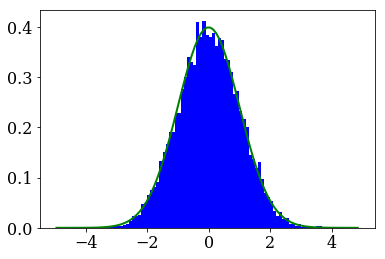

In [4]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z0,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

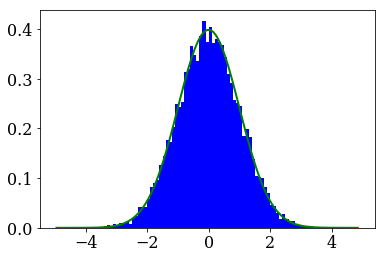

In [5]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z1,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

# Leçon 06_03

## Question 1

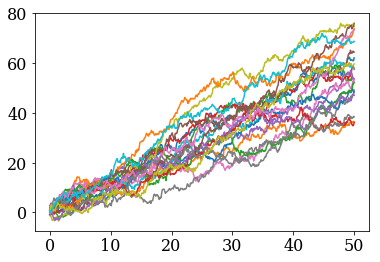

In [6]:
npart=10000
T=50.0
nt=500
dt=T/nt
alpha=2
c = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)+c*dt

for i in range(20):
    plt.plot(t,x[:,i])

On remarque une translation générale des particules vers les $x$ positifs si $c$ est positif et vers les $x$ négatifs si $c$ est négatif. 

## Question 2

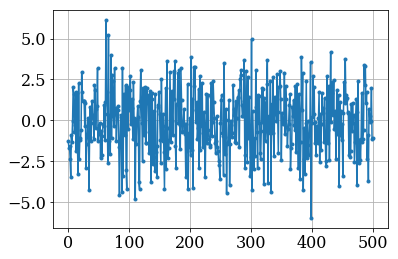

In [7]:
npart=2000
npart2plot = 1

T = 500.0
dt = 1
nt = int(T/dt)+1
alpha = 2
gamma = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(npart2plot):
    plt.plot(t,x[:,i],'.-')
plt.grid()

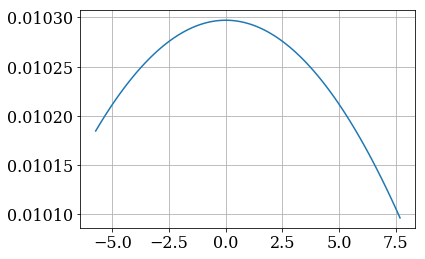

In [8]:
# Generate bins centered around 0
xmin = np.min(x[nt-1])
xmax = np.max(x[nt-1])

binwidth = (xmax-xmin)/100

bins=np.arange(xmin,xmax,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
#plt.hist(x[nt-1],bins,normed=True);

sigmat2=2*alpha*T+sigma**2-gamma*T
plt.plot(bin_centers,np.exp(-bin_centers**2/(2.0*sigmat2))/np.sqrt(2*np.pi*sigmat2))
plt.grid()

In [9]:
sigmat2

1501.0

A cause du terme de friction, on remarque une atténuation de l'écart par rapport à la position centrale pour des $\gamma <2$. Faire varier l'écart-type pour contracrrer l'effet d'un $\gamma$ trop grand?

# Remarques

Algorithme instable! On remarque que pour des $\gamma$ au-delà de 2, il y a comme une divergence.

In [10]:
npart=1

T = 10000.0
dt = 1
nt = int(T/dt)+1
alpha=2
gamma = 2.4

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(1):
    plt.plot(t[2070:2200],x[2070:2200,i],'.-')
plt.grid()

/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2907: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:436: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1032: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1042: UserWarning: Una

IndexError: index 0 is out of bounds for axis 0 with size 0

# Leçon  06_04: Modèle d'Ising

## Challenge (vers le milieu du MOOC)

## Question 1: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

Nous calculons la magnétisation moyenne comme: $$ \left \langle M \right \rangle = \dfrac{\sum_{k=1}^{N} M_k }{N} $$ avec $M_k = \sum_{i=1}^{b} s_i$ où $N$ est le nombre de tranches simulées et $b$ le nombre de cases dans une tranche dans lesquelles se trouvent les spins que nous sommons.

Commençons par définir les fonctions à utiliser pour observer l'évolution de la magnétisation pour un alpha donné.

In [2]:
def initial_state_random(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [3]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [4]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]\
                         +sp[ix,(iy+1)%ny])

    return energy

In [5]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [6]:
def moy_magn(sp): 
    """ Computes the average magnetisation for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    M: average magnetisation for the lattice state sp 
    """
    
    M = sp.sum(axis=(0,1))/(len(sp)*len(sp[0]))
    return M

In [7]:
def moy_ener(sp,alpha): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energy for the lattice state sp 
    """
    
    pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
    pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
    pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
    pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
    E = -alpha * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                  + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
    E = E/(len(sp)*len(sp[0]))
           
    return E

In [8]:
def M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling constant for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    M: magnetisation 
    E: energie 
    """
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
    return [M,E]

Calculons l'évolution de la magnétisation pour un alpha donné afin de vérifier que le code fonctionne bien.

In [9]:
NMC = 300 
step = 1
nx = 20 
ny = 20
alpha = 0.35

sp = initial_state_aligned(nx,ny)
E_aligned = moy_ener(sp,alpha)

[M,E] = M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha)

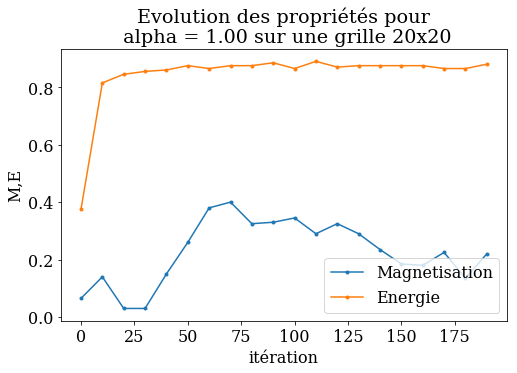

In [10]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),E/E_aligned, '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.show()

Ce graphique nous permet d'estimer le nombre d'itération nécessaire pour atteindre un équilibre statistique. Nous allons en avoir besoin pour calculer les propriétés (magnétisation et énergie) du sysème à l'équilibre. Pour automatiser ce calcul pour plusieurs valeurs de $\alpha$, il nécessaire de s'assurer que le nombre d'itération attendues pour atteindre l'équilbre majore celui nécessaire pour chaque valeur de $\alpha$. C'est pourquoi nous avons testé plusieurs valeurs de alpha et choisi pour ce graphique une valeur de alpha parmi celles qui met le plus de temps à atteindre l'équilibre pour un état initial de spins alignés. Nous avons répété plusieurs fois l'algorithme pour cette valeur et avons observé que l'équilibre était toujours atteint avant 50 itérations, nous prendrons 100 itérations pour être sûr d'avoir atteint l'équilibre. Notons que pour des valeurs de alpha proche de la transition (vers 0.4), les propriétés du système (magnétisation, énergie) fluctuent beaucoup.

Automatisons maintenant la procédure pour calculer la magnétisation à l'équilibre pour un grand nombre de couplages différents.

In [11]:
def M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq):
    """ Computes averages of physical quantities at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    Returns:
    -------
    Ms     : Vector of magnetisations at equilibrium for each alpha in alphas
    Es     : Vector of energis at equilibrium for each alpha in alphas
    VarEs  : Vector of the variances of the energy at equilibrium for each alpha in alphas
    """
    
    Ms  = np.empty([len(alphas)])
    Es  = np.empty([len(alphas)])
    VarEs = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.3f}".format(alphas[i]))
        
        for j in range(NMC_eq):
            
            #if j%(int(NMC_eq/10)+1)==0:
                #print("loop {:d} of {:d} for alpha = {:.2f} (pre-equilibrium)".format(j,NMC_eq,alphas[i]))
            for j in range(0,nx*ny):
                ix = np.random.randint(0,nx)
                iy = np.random.randint(0,ny)
                metropolis_at_site(sps[i],alphas[i],ix,iy)
        
        [M_evol,E_evol] = M_with_time_for_alpha(sps[i],nx,ny,NMC,step,alphas[i])
        Ms[i]  = M_evol.sum()/len(M_evol)
        Es[i]  = E_evol.sum()/len(E_evol)
        VarEs[i] = (E_evol**2).sum()/len(E_evol) - (E_evol.sum()/len(E_evol))**2
    
    return [Ms,Es,VarEs]

Calculons donc la magnétisation d'équilbre pour plusieurs valeurs de $\alpha$.

In [14]:
NMC = 100+500
NMC_eq = 100
step = 1
nx = 20
ny = 20
a = 101
alphas = np.linspace(0,1,a)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
E_aligned = moy_ener(sps[0],alphas)

[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)

loop at alpha = 0.000
loop at alpha = 0.010
loop at alpha = 0.020
loop at alpha = 0.030
loop at alpha = 0.040
loop at alpha = 0.050
loop at alpha = 0.060
loop at alpha = 0.070
loop at alpha = 0.080
loop at alpha = 0.090
loop at alpha = 0.100
loop at alpha = 0.110
loop at alpha = 0.120
loop at alpha = 0.130
loop at alpha = 0.140
loop at alpha = 0.150
loop at alpha = 0.160
loop at alpha = 0.170
loop at alpha = 0.180
loop at alpha = 0.190
loop at alpha = 0.200
loop at alpha = 0.210
loop at alpha = 0.220
loop at alpha = 0.230
loop at alpha = 0.240
loop at alpha = 0.250
loop at alpha = 0.260
loop at alpha = 0.270
loop at alpha = 0.280
loop at alpha = 0.290
loop at alpha = 0.300
loop at alpha = 0.310
loop at alpha = 0.320
loop at alpha = 0.330
loop at alpha = 0.340
loop at alpha = 0.350
loop at alpha = 0.360
loop at alpha = 0.370
loop at alpha = 0.380
loop at alpha = 0.390
loop at alpha = 0.400
loop at alpha = 0.410
loop at alpha = 0.420
loop at alpha = 0.430
loop at alpha = 0.440
loop at al

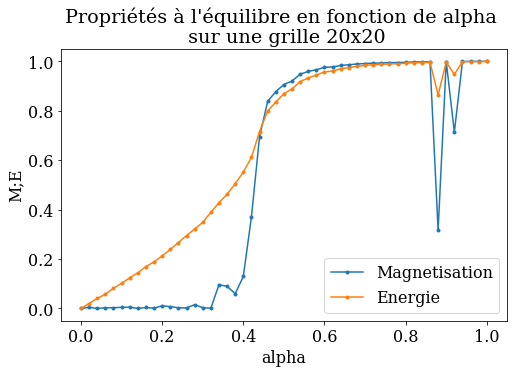

In [19]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.show()

Notons que nous affichons la valeur absolue de la magnétisation, car celle-ci peut converger vers n'importe laquelle des deux orientations. En ce qui concerne l'énergie, nous la divisons par la valeur d'énergie pour un réseau de spins entièrement alignés et prenons ensuite la valeur absolue.

Remarquons que la magnétisation et l'énergie ne se comportent pas de la même façon. Pour de petites valeurs de $\alpha$, la courbe d'énergie se trouve bien au dessus de la magnétisation, cela s'explique par le fait que plus $\alpha$ est grand, plus les spins voisins on tendance à s'aligner et diminuent l'énergie totale, alors que comme se phénomène d'alignement n'a pas lieu à grande échelle, la magnétisation reste petite. En effet, les contributions des différentes zones alignées se compensent et annulent la magnétisation totale. 

Quand nous partons d'une grille de spins désordonnés, nous observons parfois de vaste régions (de taille comparable à celle du système) de spins alignés dans une direction particulière, différente d'une région à l'autre. Ces régions sont l'analogue dans ce modèles des varitables domaines de Weiss que l'on observe dans un matériau ferromagnétique. Ces domaines de Weiss on pour effet de diminuer fortement la magnétisation pour certaines valeurs de $\alpha$ pourtant au dessus de la valeur critique, alors que comme l'énergie est sommée sur les paires voisines, l'orientation différente des domaines ne se ressent qu'à la frontière entre ceux-ci et les diminutions sont donc beaucoup plus petites.

$<$ insérer image de domaine de weiss et graphique des paramètres en fonction de alpha montrant le phénomène -> partie de maxime $>$

Sur ce graphique des propriétés à l'équibre en fonction du couplage, nous pouvons observer une nette augmention de la magnétisation totale à partir de $\alpha = 0.4$. Cela nous permet de fournir une première estimation de la valeur critique de $\alpha$, que l'on estime à environ $0.4$.

Pour plus de précision sur cette valeur, nous pouvons définir le couplage critique comme la valeur de $\alpha$ où la courbe de magnétisation passe au dessus de $0.5$. Ce point est arbitraire mais vu la valeur très élevée de la pente près du vrai couplage critique, cela devrait constituer une bonne approximation de ce dernier.

In [96]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} $\pm$ {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.43 \pm 0.02


Ce résultat est proche de la valeur théorique obtenue par Onsager, qui est:

$$ \alpha = \frac{\ln( 1+\sqrt 2 )}{2} \approx 0.441$$

Gardons évidemment en tête que ce résultat est valable dans la limite où le réseau est de taille infine, le nôtre n'étant consititué que de 20x20 spins.

Cependant, une méthode plus précise existe pour déterminer cette valeur critique. Elle consiste à observer la capacité calorifique en fonction de $\alpha$, le graphique devant présenter un pic à la valeur critique de couplage.

Nous avons relancé une simulation beaucoup plus précise s'étalant sur plusieurs heures de calcul et analysé les résultats dans un **notebook en annexe** ("Compute_Cv_Ising_MJ_CS.ipynb").

Nous avons obtenu comme couplage critique pour une grille de $20\times20$ spins la valeur suivante:

$$ \alpha = 0.4343(2) $$

## Question 2

Faisons à présent varier les conditions aux bords et les conditions initiales. 

In [16]:
def edges_conditions(sp,borders):
    """Fixes the boundary conditions
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    borders   : array
        Array of 4 numbers to fix the boundary conditions. The first indice is for the top line, the second one for 
        the left row and so on.
    """
    sp[0,:] = borders[0]*np.ones([1,ny])
    sp[:,[0]] = borders[1]*np.ones([nx,1])
    sp[-1,:] = borders[2]*np.ones([1,ny])
    sp[:,[-1]] = borders[3]*np.ones([nx,1])
    
    return sp

In [17]:
def square_center(sp,a):
    """Fixes the boundary conditions in a square at the center of the frames
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    a   : int
        Allow to choose the value of the spins inside the square
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp[int(nx/4)+1:3*int(nx/4),int(ny/4)+1:3*int(ny/4)] = a*np.ones([int(nx/2)+1,int(ny/2)+1])
    
    return sp

In [18]:
def init_chessboard(sp):
    """Imposes that one out of two compartments in the initial frame is +1 and the other one -1, as a chessboard
    
    Parameters:
    ----------
    sp   : array
        The matrix "sp" must be initialized before using this function
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp = np.ones([nx,ny])
    
    for i in range(nx):
        for j in range(ny):
            if (i+j)%2==1:
                sp[i,j] = -1
                
    return sp

In [19]:
def metropolis_at_site(sp,alpha,ix,iy,param,borders,a):
    """ Flips a dipole at site ix, iy when probability condition is met and refix the boundary conditions
   
    Parameters:
    ----------
    sp   : numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    param   : int
        Allow to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allow to choose the value of the spins inside the square 
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]
        
    # Fix the boundary conditions
    if param==1:
        sp = edges_conditions(sp,borders)        
    
    elif param==2:
        sp = square_center(sp,a)
    
    elif param==3:
        sp = edges_conditions(sp,borders)
        sp = square_center(sp,a)
        
    return sp

In [20]:
def M_with_time_for_alpha(sp,NMC,step,alpha,param,borders,a):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling 
    constant for the Ising model using the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    param   : int
        Allow to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allow to choose the value of the spins inside the square 
        
    Returns:
    -------
    M: magnetisation 
    E: energy
    """
    
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
            
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy,param,borders,a)
            
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
            
    return [M,E]

In [21]:
def M_equilibrium_for_alphas(sps,NMC,step,alphas,NMC_eq,param,borders,a):
    """ Computes the average magnetisation and energy at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    
    Returns:
    -------
    Ms: Vector of magnetisations at equilibrium for each alpha in alphas
    Es: Vector of energies at equilibrium for each alpha in alphas
    """
    nx = np.shape(sps[0])[0]
    ny = np.shape(sps[0])[1]
    
    Ms = np.empty([len(alphas)])
    Es = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        #print("loop at alpha = {:.2f}".format(alphas[i]))
        
        for j in range(NMC_eq):
            
            if j%(int(NMC_eq/10)+1)==0:
                print("loop {:d} of {:d} for alpha = {:.2f} (pre-equilibrium)".format(j,NMC_eq,alphas[i]))
                
            for j in range(0,nx*ny):
                ix=np.random.randint(0,nx)
                iy=np.random.randint(0,ny)
                metropolis_at_site(sps[i],alphas[i],ix,iy,param,borders,a)
        
        [M_evol,E_evol] = M_with_time_for_alpha(sps[i],NMC,step,alphas[i],param,borders,a)
        
        Ms[i] = M_evol.sum()/len(M_evol)
        Es[i] = E_evol.sum()/len(E_evol)
    
    return [Ms,Es]

In [23]:
NMC = 600
NMC_eq = 400
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 51
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
#    sps[i] = initial_state_random(nx,ny)
     sps[i] = init_chessboard(sps[i])
    


[Ms,Es] = M_equilibrium_for_alphas(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop 0 of 400 for alpha = 0.00 (pre-equilibrium)
loop 41 of 400 for alpha = 0.00 (pre-equilibrium)
loop 82 of 400 for alpha = 0.00 (pre-equilibrium)
loop 123 of 400 for alpha = 0.00 (pre-equilibrium)
loop 164 of 400 for alpha = 0.00 (pre-equilibrium)
loop 205 of 400 for alpha = 0.00 (pre-equilibrium)
loop 246 of 400 for alpha = 0.00 (pre-equilibrium)
loop 287 of 400 for alpha = 0.00 (pre-equilibrium)
loop 328 of 400 for alpha = 0.00 (pre-equilibrium)
loop 369 of 400 for alpha = 0.00 (pre-equilibrium)
loop 0 of 400 for alpha = 0.02 (pre-equilibrium)
loop 41 of 400 for alpha = 0.02 (pre-equilibrium)
loop 82 of 400 for alpha = 0.02 (pre-equilibrium)
loop 123 of 400 for alpha = 0.02 (pre-equilibrium)
loop 164 of 400 for alpha = 0.02 (pre-equilibrium)
loop 205 of 400 for alpha = 0.02 (pre-equilibrium)
loop 246 of 400 for alpha = 0.02 (pre-equilibrium)
loop 287 of 400 for alpha = 0.02 (pre-equilibrium)
loop 328 of 400 for alpha = 0.02 (pre-equilibrium)
loop 369 of 400 for alpha = 0.02 (pre-e

loop 82 of 400 for alpha = 0.32 (pre-equilibrium)
loop 123 of 400 for alpha = 0.32 (pre-equilibrium)
loop 164 of 400 for alpha = 0.32 (pre-equilibrium)
loop 205 of 400 for alpha = 0.32 (pre-equilibrium)
loop 246 of 400 for alpha = 0.32 (pre-equilibrium)
loop 287 of 400 for alpha = 0.32 (pre-equilibrium)
loop 328 of 400 for alpha = 0.32 (pre-equilibrium)
loop 369 of 400 for alpha = 0.32 (pre-equilibrium)
loop 0 of 400 for alpha = 0.34 (pre-equilibrium)
loop 41 of 400 for alpha = 0.34 (pre-equilibrium)
loop 82 of 400 for alpha = 0.34 (pre-equilibrium)
loop 123 of 400 for alpha = 0.34 (pre-equilibrium)
loop 164 of 400 for alpha = 0.34 (pre-equilibrium)
loop 205 of 400 for alpha = 0.34 (pre-equilibrium)
loop 246 of 400 for alpha = 0.34 (pre-equilibrium)
loop 287 of 400 for alpha = 0.34 (pre-equilibrium)
loop 328 of 400 for alpha = 0.34 (pre-equilibrium)
loop 369 of 400 for alpha = 0.34 (pre-equilibrium)
loop 0 of 400 for alpha = 0.36 (pre-equilibrium)
loop 41 of 400 for alpha = 0.36 (pre-e

loop 164 of 400 for alpha = 0.64 (pre-equilibrium)
loop 205 of 400 for alpha = 0.64 (pre-equilibrium)
loop 246 of 400 for alpha = 0.64 (pre-equilibrium)
loop 287 of 400 for alpha = 0.64 (pre-equilibrium)
loop 328 of 400 for alpha = 0.64 (pre-equilibrium)
loop 369 of 400 for alpha = 0.64 (pre-equilibrium)
loop 0 of 400 for alpha = 0.66 (pre-equilibrium)
loop 41 of 400 for alpha = 0.66 (pre-equilibrium)
loop 82 of 400 for alpha = 0.66 (pre-equilibrium)
loop 123 of 400 for alpha = 0.66 (pre-equilibrium)
loop 164 of 400 for alpha = 0.66 (pre-equilibrium)
loop 205 of 400 for alpha = 0.66 (pre-equilibrium)
loop 246 of 400 for alpha = 0.66 (pre-equilibrium)
loop 287 of 400 for alpha = 0.66 (pre-equilibrium)
loop 328 of 400 for alpha = 0.66 (pre-equilibrium)
loop 369 of 400 for alpha = 0.66 (pre-equilibrium)
loop 0 of 400 for alpha = 0.68 (pre-equilibrium)
loop 41 of 400 for alpha = 0.68 (pre-equilibrium)
loop 82 of 400 for alpha = 0.68 (pre-equilibrium)
loop 123 of 400 for alpha = 0.68 (pre-e

loop 246 of 400 for alpha = 0.96 (pre-equilibrium)
loop 287 of 400 for alpha = 0.96 (pre-equilibrium)
loop 328 of 400 for alpha = 0.96 (pre-equilibrium)
loop 369 of 400 for alpha = 0.96 (pre-equilibrium)
loop 0 of 400 for alpha = 0.98 (pre-equilibrium)
loop 41 of 400 for alpha = 0.98 (pre-equilibrium)
loop 82 of 400 for alpha = 0.98 (pre-equilibrium)
loop 123 of 400 for alpha = 0.98 (pre-equilibrium)
loop 164 of 400 for alpha = 0.98 (pre-equilibrium)
loop 205 of 400 for alpha = 0.98 (pre-equilibrium)
loop 246 of 400 for alpha = 0.98 (pre-equilibrium)
loop 287 of 400 for alpha = 0.98 (pre-equilibrium)
loop 328 of 400 for alpha = 0.98 (pre-equilibrium)
loop 369 of 400 for alpha = 0.98 (pre-equilibrium)
loop 0 of 400 for alpha = 1.00 (pre-equilibrium)
loop 41 of 400 for alpha = 1.00 (pre-equilibrium)
loop 82 of 400 for alpha = 1.00 (pre-equilibrium)
loop 123 of 400 for alpha = 1.00 (pre-equilibrium)
loop 164 of 400 for alpha = 1.00 (pre-equilibrium)
loop 205 of 400 for alpha = 1.00 (pre-e

In [ ]:
[Ms,Es] = M_equilibrium_for_alphas(sps,NMC,step,alphas,NMC_eq,1,np.array([1,1,1,1]),1)

In [42]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas,abs(Es/E_aligned), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.show()

NameError: name 'Ms' is not defined

In [ ]:
index_Weiss = -1
for i in range(len(alphas)):
    if (abs(Ms[i])<0.5) & (alphas[i]>0.6):
        index_Weiss = i

print(index_Weiss)

plt.figure(figsize=(6,6))
plt.imshow(sps[36],interpolation="none",origin='lower');

In [ ]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

## Remarques